# Negative binomial Bayesian

Using a simulated data set

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-negative-binomial-regression.html

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import arviz as az
import bambi as bmb

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
from scipy import stats

In [6]:
az.style.use('arviz-darkgrid')

In [7]:
warnings.simplefilter("ignore")

## Utility functions

In [8]:
pal = sns.color_palette()

In [9]:
def generate_poisson_data(
    noalcohol_meds, alcohol_meds, noalcohol_nomeds, alcohol_nomeds, size
):
    return pd.DataFrame(
        {
            "nsneeze": np.concatenate(
                (
                    rng.poisson(noalcohol_meds, size),
                    rng.poisson(alcohol_meds, size),
                    rng.poisson(noalcohol_nomeds, size),
                    rng.poisson(alcohol_nomeds, size),
                )
            ),
            "alcohol": np.concatenate(
                (
                    np.repeat(False, size),
                    np.repeat(True, size),
                    np.repeat(False, size),
                    np.repeat(True, size),
                )
            ),
            "nomeds": np.concatenate(
                (
                    np.repeat(False, size),
                    np.repeat(False, size),
                    np.repeat(True, size),
                    np.repeat(True, size),
                )
            ),
        }
    )

In [10]:
def get_neg_binomial_values(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """
    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

In [11]:
def generate_neg_binomial_data(
    noalcohol_meds, alcohol_meds, noalcohol_nomeds, alcohol_nomeds, size
):
    alpha = 10

    return pd.DataFrame(
        {
            "nsneeze": np.concatenate(
                (
                    get_neg_binomial_values(noalcohol_meds, alpha, size),
                    get_neg_binomial_values(alcohol_meds, alpha, size),
                    get_neg_binomial_values(noalcohol_nomeds, alpha, size),
                    get_neg_binomial_values(alcohol_nomeds, alpha, size),
                )
            ),
            "alcohol": np.concatenate(
                (
                    np.repeat(False, size),
                    np.repeat(True, size),
                    np.repeat(False, size),
                    np.repeat(True, size),
                )
            ),
            "nomeds": np.concatenate(
                (
                    np.repeat(False, size),
                    np.repeat(False, size),
                    np.repeat(True, size),
                    np.repeat(True, size),
                )
            ),
        }
    )

## Get data

In [12]:
RANDOM_SEED = 1234
rng = np.random.default_rng(RANDOM_SEED)

In [13]:
# Mean Poisson values
noalcohol_meds = 1  # no alcohol, took an antihist
alcohol_meds = 3  # alcohol, took an antihist
noalcohol_nomeds = 6  # no alcohol, no antihist
alcohol_nomeds = 36  # alcohol, no antihist

size = 1000

Poisson distribution has mean equal variance

In [14]:
df_poisson = generate_poisson_data(
    noalcohol_meds, alcohol_meds, noalcohol_nomeds, alcohol_nomeds, size
)

Negative binomial distribution can have mean not equal variance

In [15]:
df_neg_binomial = generate_neg_binomial_data(
    noalcohol_meds, alcohol_meds, noalcohol_nomeds, alcohol_nomeds, size
)

In [16]:
df_poisson.groupby(['nomeds', 'alcohol']).agg(
    mean_nsneeze=('nsneeze', np.mean), var_nsneeze=('nsneeze', np.var)
).reset_index()

,nomeds,alcohol,mean_nsneeze,var_nsneeze
0,False,False,1.019,1.077717
1,False,True,3.018,2.910587
2,True,False,5.950,6.331832
3,True,True,36.075,33.402778


In [17]:
df_neg_binomial.groupby(['nomeds', 'alcohol']).agg(
    mean_nsneeze=('nsneeze', np.mean), var_nsneeze=('nsneeze', np.var)
).reset_index()

,nomeds,alcohol,mean_nsneeze,var_nsneeze
0,False,False,0.991,1.118037
1,False,True,2.986,3.835640
2,True,False,6.023,9.732203
3,True,True,35.674,163.603327


## Plot data

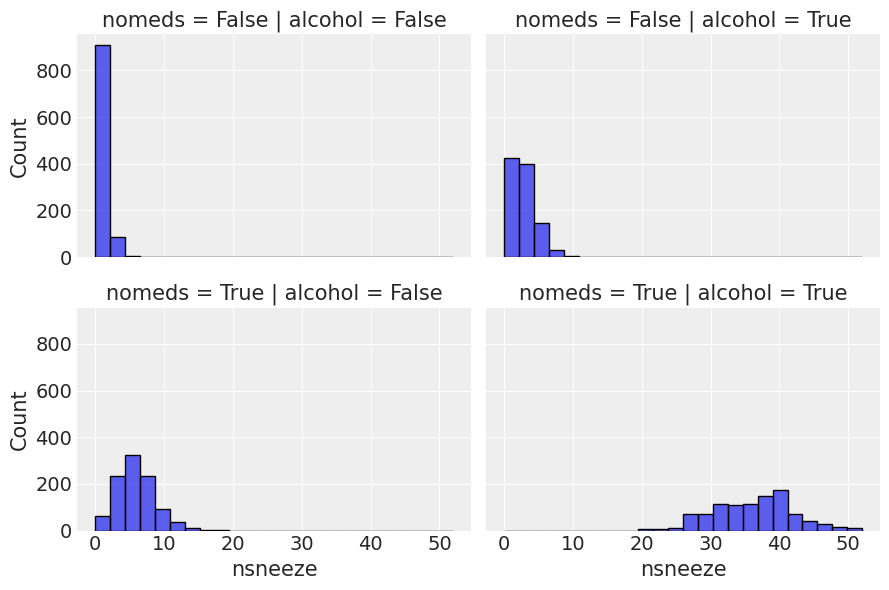

In [18]:
sns.displot(
    x="nsneeze",
    row="nomeds",
    col="alcohol",
    data=df_poisson,
    aspect=1.5,
    height=3,
)

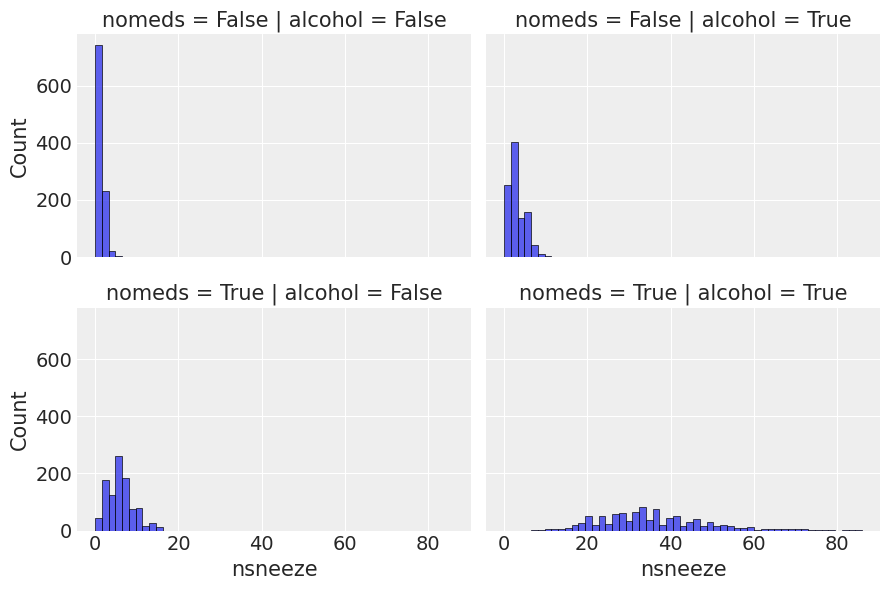

In [19]:
sns.displot(
    x="nsneeze",
    row="nomeds",
    col="alcohol",
    data=df_neg_binomial,
    aspect=1.5,
    height=3,
)

## Inference

In [20]:
formula = "nsneeze ~ alcohol + nomeds + alcohol:nomeds"

### Poisson family

In [21]:
model_poisson = bmb.Model(formula, df_poisson, family="poisson")
idata_poisson = model_poisson.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol:nomeds, nomeds, alcohol, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


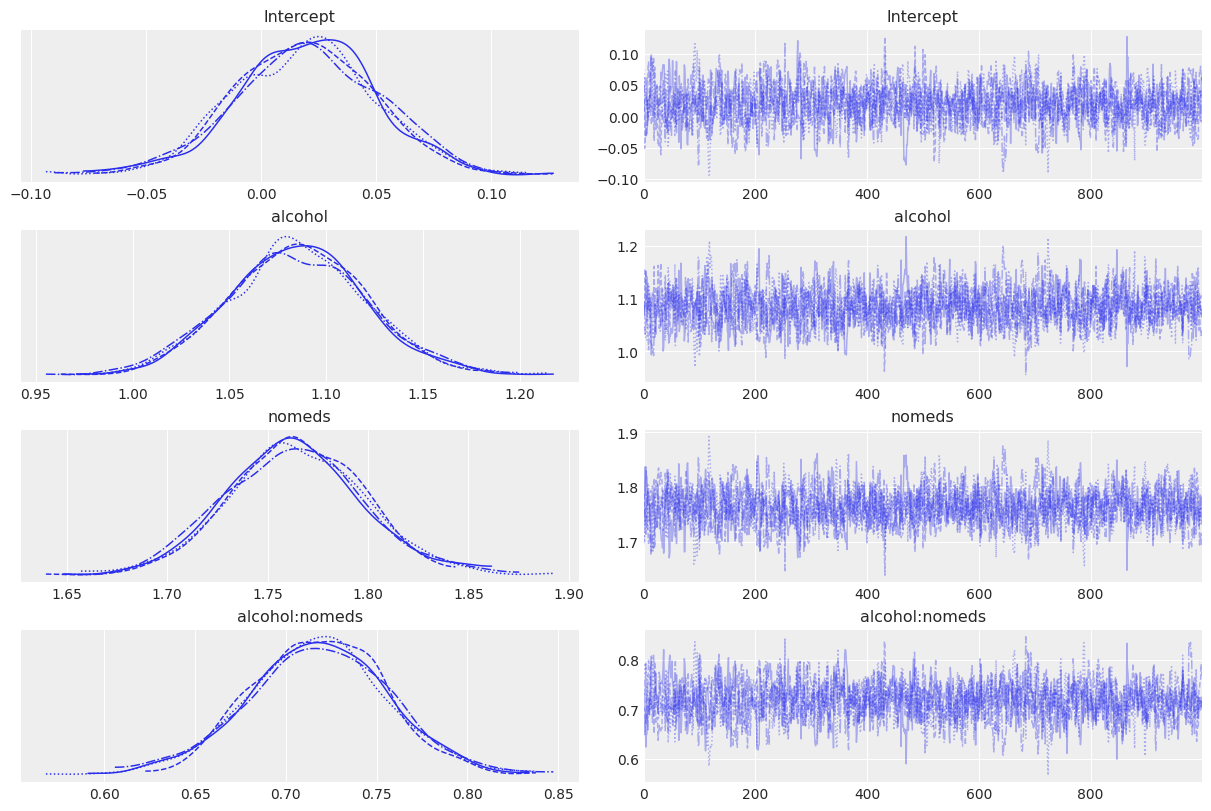

In [22]:
_ = az.plot_trace(idata_poisson)

In [25]:
az.summary(idata_poisson)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.020,0.031,-0.035,0.080,0.001,0.001,1134.0,1388.0,1.0
alcohol,1.085,0.035,1.015,1.148,0.001,0.001,1176.0,1595.0,1.0
nomeds,1.764,0.033,1.698,1.824,0.001,0.001,1126.0,1399.0,1.0
alcohol:nomeds,0.718,0.038,0.649,0.792,0.001,0.001,1113.0,1442.0,1.0


### Negative binomial family

In [23]:
model_neg_binomial = bmb.Model(
    formula, df_neg_binomial, family="negativebinomial"
)
idata_neg_binomial = model_neg_binomial.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nsneeze_alpha, alcohol:nomeds, nomeds, alcohol, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


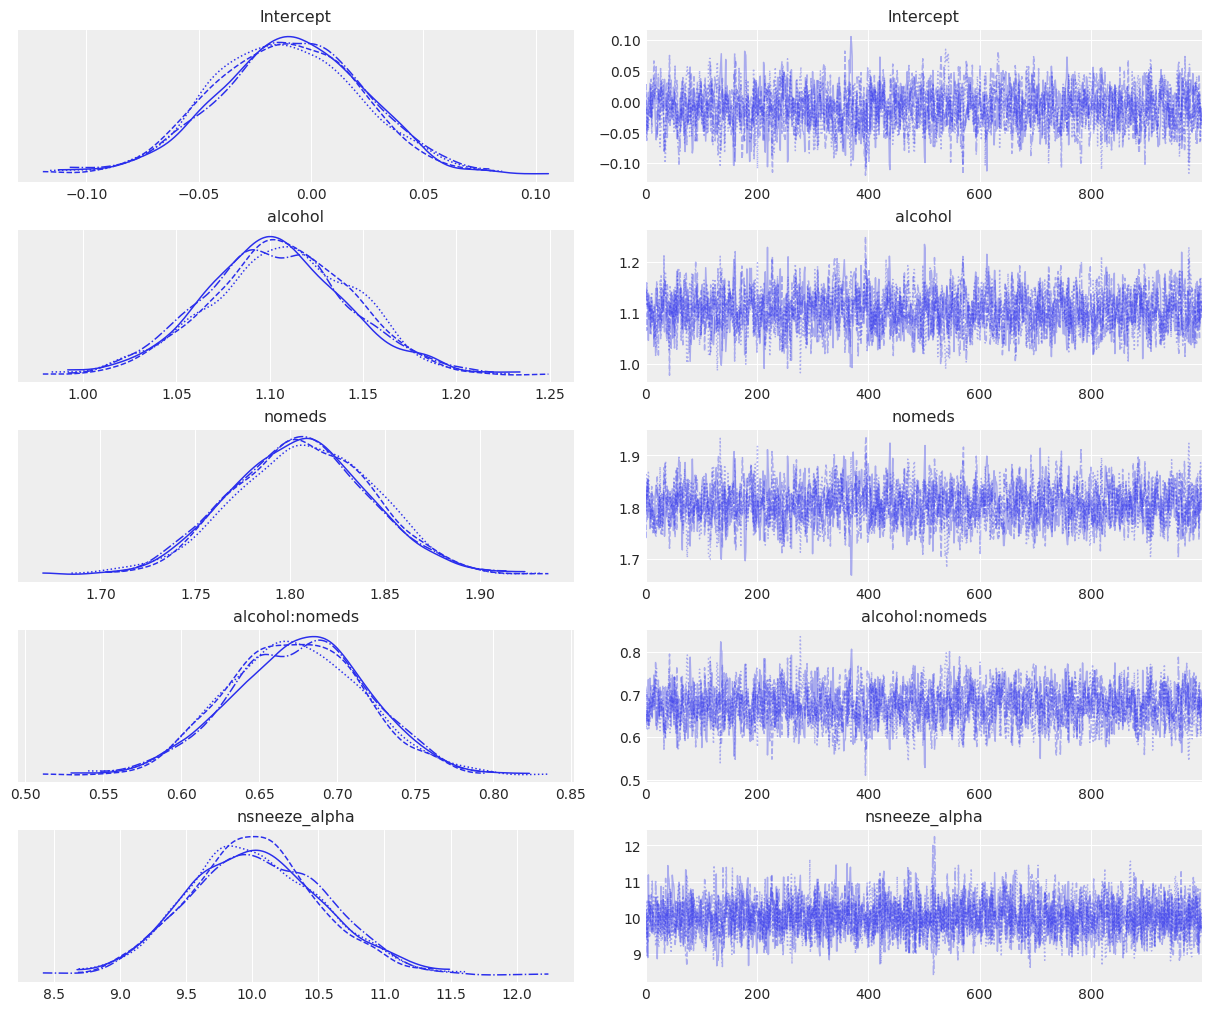

In [24]:
_ = az.plot_trace(idata_neg_binomial)

In [26]:
az.summary(idata_neg_binomial)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.011,0.033,-0.069,0.051,0.001,0.001,1457.0,1940.0,1.0
alcohol,1.105,0.038,1.030,1.176,0.001,0.001,1515.0,2174.0,1.0
nomeds,1.806,0.036,1.735,1.871,0.001,0.001,1484.0,2208.0,1.0
alcohol:nomeds,0.674,0.043,0.594,0.755,0.001,0.001,1469.0,2236.0,1.0
nsneeze_alpha,10.023,0.499,9.152,11.007,0.009,0.006,3389.0,2419.0,1.0
